# Spatio-temporal Transcriptomics

Toy dataset from López-Lopera et al. (2019)

- Data download: https://github.com/anfelopera/PhysicallyGPDrosophila

In [1]:
import numpy as np
import torch

from torch.nn import Parameter
from torch.optim import Adam
from gpytorch.optim import NGD
from gpytorch.constraints import Interval
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import path

from lafomo.utilities.torch import get_image
from lafomo.datasets import DrosophilaSpatialTranscriptomics
from lafomo.models import MultiOutputGP, PartialLFM
from lafomo.models.pdes import ReactionDiffusion
from lafomo.datasets import ToySpatialTranscriptomics, P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.plot import Plotter, plot_spatiotemporal_data
from lafomo.trainers import PDETrainer
from lafomo.utilities.torch import discretise, softplus
from lafomo.utilities.fenics import interval_mesh


In [2]:
kr_dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data')
kni_dataset = DrosophilaSpatialTranscriptomics(gene='kni', data_dir='../../../data')
gt_dataset = DrosophilaSpatialTranscriptomics(gene='gt', data_dir='../../../data')

drosophila = False

if drosophila:
    filepath = path.join('../../../experiments', 'dros-kr', 'partial', 'savedmodel')

    dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data')

    data = next(iter(dataset))
    tx, y_target = data
    lengthscale = 10
    images = [get_image(dataset.orig_data, i)
          for i in range(2, 4)
          for dataset in [kr_dataset, kni_dataset, gt_dataset]
          ]

else:
    filepath = path.join('../../../experiments', 'toy-spatial', 'partial', 'savedmodel')

    dataset = ToySpatialTranscriptomics(data_dir='../../../data/')
    data = next(iter(dataset))
    tx, y_target = data
    lengthscale = 0.2

num_inducing = int(tx.shape[1] * 5/6)

ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
t_diff = ts[-1]-ts[0]
x_diff = xs[-1]-xs[0]
extent = [ts[0], ts[-1], xs[0], xs[-1]]

if drosophila: plot_spatiotemporal_data(images, extent, nrows=2, ncols=3)

We can either create a simple unit interval mesh

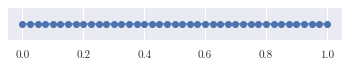

In [3]:
from dolfin import *

mesh = UnitIntervalMesh(40)
plot(mesh)

Alternatively, if our spatial data is not uniformly spaced, we can define a custom mesh as follows.

Matching: True


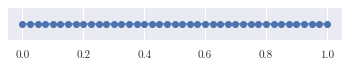

In [4]:
# We calculate a mesh that contains all possible spatial locations in the dataset

spatial = np.unique(tx[1, :])
mesh = interval_mesh(spatial)
plot(mesh)
# The mesh coordinates should match up to the data:
print('Matching:', all(spatial == mesh.coordinates().reshape(-1)))

Set up GP model

torch.Size([1, 504, 2])


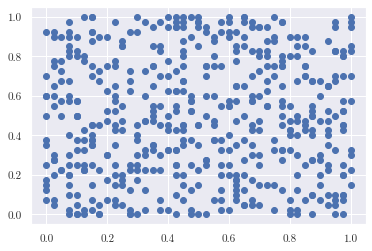

In [5]:
inducing_points = torch.stack([
    tx[0, torch.randperm(tx.shape[1])[:int(0.3 * tx.shape[1])]],
    tx[1, torch.randperm(tx.shape[1])[:int(0.3 * tx.shape[1])]]
], dim=1).unsqueeze(0)

gp_kwargs = dict(use_ard=True,
                 use_scale=False,
                 # lengthscale_constraint=Interval(0.1, 0.3),
                 learn_inducing_locations=False,
                 initial_lengthscale=lengthscale)
gp_model = MultiOutputGP(inducing_points, 1, **gp_kwargs)
gp_model.double();

print(inducing_points.shape)
plt.scatter(inducing_points[0,:,0], inducing_points[0, :, 1])

Set up PDE

In [6]:
t_range = (ts[0], ts[-1])
print(t_range)
time_steps = dataset.num_discretised
print(time_steps)

fenics_model = ReactionDiffusion(t_range, time_steps, mesh)

config = VariationalConfiguration(
    initial_conditions=False,
    num_samples=25
)

sensitivity = Parameter(torch.ones((1, 1), dtype=torch.float64), requires_grad=False)
decay = Parameter(0.1*torch.ones((1, 1), dtype=torch.float64), requires_grad=False)
diffusion = Parameter(0.01*torch.ones((1, 1), dtype=torch.float64), requires_grad=False)
fenics_params = [sensitivity, decay, diffusion]

lfm = PartialLFM(1, gp_model, fenics_model, fenics_params, config)

(0.0, 1.0)
40


In [9]:
train_mask = torch.zeros_like(tx[0,:])
train_mask[torch.randperm(tx.shape[1])[:int(0.3 * tx.shape[1])]] = 1

num_training = tx.shape[1]
variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.07)
optimizers = [variational_optimizer, parameter_optimizer]

trainer = PDETrainer(lfm,
                     optimizers,
                     dataset,
                     track_parameters=list(lfm.fenics_named_parameters.keys()),
                     train_mask=train_mask.bool(),
                     warm_variational=1)

t_sorted, dp [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ] 0.025
x dp is set to 0.025
t_sorted, dp [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ] 0.025


Now let's see some samples from the GP and corresponding LFM output


KeyboardInterrupt: 

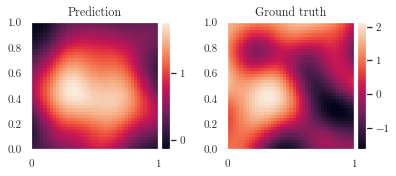

<Figure size 432x288 with 0 Axes>

In [10]:
num_t = trainer.tx[0, :].unique().shape[0]
num_x = trainer.tx[1, :].unique().shape[0]

# gp_model.covar_module.lengthscale = 0.3*0.3 * 2
out = gp_model(trainer.tx.transpose(0, 1))

sample = out.sample(torch.Size([lfm.config.num_samples])).permute(0, 2, 1)
real = torch.tensor(dataset.orig_data[trainer.t_sorted, 2]).unsqueeze(0)


plot_spatiotemporal_data(
    [sample.mean(0)[0].detach().view(num_t, num_x).transpose(0, 1),
    real.squeeze().view(num_t, num_x).transpose(0, 1)],
    extent,
    titles=['Prediction', 'Ground truth']
)

sample = sample.view(lfm.config.num_samples, 1, num_t, num_x)
real = real.repeat(lfm.config.num_samples, 1, 1)
real = real.view(lfm.config.num_samples, 1, num_t, num_x)

out = lfm.solve_pde(sample)
real_out = lfm.solve_pde(real)

plot_spatiotemporal_data(
    [out.mean(0).detach().transpose(0, 1),
    real_out[0].detach().transpose(0, 1)],
    extent,
    titles=['Prediction', 'Ground truth']
)

In [ ]:
#print(hihi)

trainer.train(2)

In [24]:
print(sample.shape)

plt.imshow(sample.mean(0)[0].transpose(0, 1))
plt.colorbar()
plt.figure()
plt.imshow(out.mean(0).detach())
# lfm.save(filepath)

torch.Size([25, 1, 512])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [25]:
lfm = PartialLFM.load(filepath,
                      gp_cls=MultiOutputGP,
                      gp_args=[inducing_points, 1],
                      gp_kwargs=gp_kwargs,
                      lfm_args=[1, fenics_model, fenics_params, config])
# lfm = PartialLFM(gp_model, fenics_model, fenics_params, config)

gp_model = lfm.gp_model
optimizer = torch.optim.Adam(lfm.parameters(), lr=0.07)
trainer = PDETrainer(lfm, optimizer, dataset, track_parameters=list(lfm.fenics_named_parameters.keys()))

t_sorted, dp [53.925 60.175 66.425 72.675 78.925 85.175 91.425 97.675] 6.25
x dp is set to 1.0
t_sorted, dp [25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5
 39.5 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5
 53.5 54.5 55.5 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5
 67.5 68.5 69.5 70.5 71.5 72.5 73.5 74.5 75.5 76.5 77.5 78.5 79.5 80.5
 81.5 82.5 83.5 84.5 85.5 86.5 87.5 88.5] 1.0


In [26]:
from lafomo.utilities.torch import smse, cia, q2

tx = trainer.tx
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]
# f_mean = lfm(tx).mean.detach()
# f_var = lfm(tx).variance.detach()
y_target = trainer.y_target[0]
ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
t_diff = ts[-1] - ts[0]
x_diff = xs[-1] - xs[0]
extent = [ts[0], ts[-1], xs[0], xs[-1]]
print(y_target.shape, f_mean.squeeze().shape)
f_mean_test = f_mean.squeeze()
f_var_test = f_var.squeeze()

print(q2(y_target, f_mean.squeeze()))
print(cia(y_target, f_mean_test, f_var_test).item())
print(smse(y_target, f_mean_test).mean().item())

NameError: name 'f_mean' is not defined

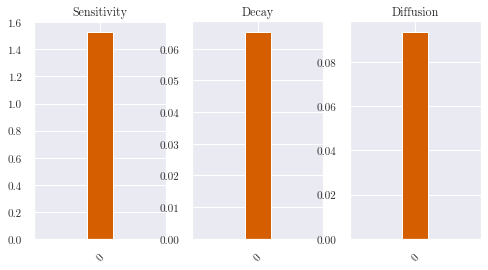

In [32]:
plotter = Plotter(lfm, np.arange(1))

labels = ['Sensitivity', 'Decay', 'Diffusion']
kinetics = list()
for key in lfm.fenics_named_parameters.keys():
    kinetics.append(softplus(trainer.parameter_trace[key][-1]).squeeze().numpy())

plotter.plot_double_bar(kinetics, labels)

# plotter.plot_latents()